<a href="https://colab.research.google.com/github/Samantha-Hampton/COVID_modeling/blob/master/COVID_19_SARAO_Bounding_Epidemiological_Model_0_4_Provincial_SH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARAO Epidemiological Model

Objective

The objective of the model is to estimate the upper and lower bounds for total demand for hospitalization to aid with production planning for the National Ventilator Project executed by SARAO.

Disclaimer: this is a purely mathematical model and is not intended other than...

### Imports

In [12]:
!pip install wget
!pip install ssl

import wget
import ssl
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy import stats

import warnings

from scipy import optimize
from scipy.optimize import brentq, newton

# set these constants to incluse the effects of: 
# ICU facilities becoming overwhelmed
ICU_OVERWHELM = True
# R_t being modified due to number of deaths:
DEATH_REACTIVE_R_T = True

  Using cached https://files.pythonhosted.org/packages/83/21/f469c9923235f8c36d5fd5334ed11e2681abad7e0032c5aba964dcaf9bbb/ssl-1.16.tar.gz
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


### SEIR-model
We use a class of what is known as compartmental models in which individuals in a population are divided into different compartments depending on predetermined epidemiological properties. Within each compartment, individuals are assumed to have the same characteristics and act in the same way. These are mean-field models, tracking spatially averaged population qualities as they vary over time, with individuals assumed to be homogenous within compartments. The compartments are denoted S as in susceptible, E as in exposed, I as in infected, H as in hospitalised, C as in critical and potentially requiring ICU facility, R as in recovered, and D as in deceased.

When a healthy individual gets infected, he or she does not become infectious at once but enters the symptom-free phase E and remains in that compartment for an average incubation time or latency period, t_inc = 1/sigma.
We divide infectious cases into two groups: reported cases and unreported cases. After the incubation period, an infected individual either is tested through the public or private health care sector and becomes a confirmed and reported case or remains unconfirmed, i.e. an unreported case.

The average time during which an infected individual is infectious is t_inf.

We assume a closed population, which is justified under a model of the rapid spread of a pathogen; that is, we neglect births, and deaths due to other causes in our modeled population. We denote the number of individuals in each compartment by S, E, I_r, I_u, H, C, R, and D, the sum of which is the population size, N.

## Transmission Dynamics

In [0]:
# Susceptible
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S

# Exposed
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)

# Infected
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)

# Hospitalized 
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, frac_mild_total, frac_fatal):
    return ((1 - frac_mild_total) * (I / t_inf)) + ((1 - frac_fatal) * C / t_crit) - (H / t_hosp)

# Critical
def dC_dt(H, C, t_hosp, t_crit, frac_crit):
    return (frac_crit * H / t_hosp) - (C/t_crit)
    # return (frac_crit * H / t_hosp) - (1-frac_fatal)*(C/t_crit) - frac_fatal*(C/t_crit)
    # i.e.  = (term gained from Hospitalised) - (term lost to Hospitalised) - (term lost to Deaths)
    #       = (term gained from H) - (terms lost to both H and D)

# Recovered
def dR_dt(I, H, t_inf, t_hosp, frac_mild_total, frac_crit):
    return (frac_mild_total * I / t_inf) + (1 - frac_crit) * (H / t_hosp)

# Deaths
def dD_dt(C, t_crit, frac_fatal):
    return frac_fatal * (C/t_crit)


def SEIR_HCD_model(t, y, R_t, t_inc=2.9, t_inf=6.1, t_hosp=4, t_crit=10, frac_mild_total=0.96, frac_crit=0.2, frac_fatal=0.2):
    """
    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Time-varying reproductive number
    :param t_inc: Average incubation period. 
    :param t_inf: Average infectious period. 
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical.
    :param t_crit: Average time a patient is in a critical state (either recovers or dies).
    :param frac_mild_total: Fraction of infections that are asymptomatic or mild.      
    :param frac_crit: Fraction of severe cases that turn critical.                      
    :param frac_fatal: Fraction of critical cases that are fatal.                   
    :return:
    """
    
    # Evaluate R_t if it is a function, otherwise use it as is
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t

    S, E, I, R, H, C, D = y
    
    
    # account for ICU overload by modifying the fatality ratio
    if ICU_OVERWHELM:
      ICU_CAPACITY = 4000/N # [ref for ICU capacity?]
      if C > ICU_CAPACITY:
        frac_fatal = (ICU_CAPACITY/C)*frac_fatal + ((C - ICU_CAPACITY)/C)*np.minimum(0.85, np.random.normal(0.75, 0.10))
        #frac_fatal =  (patients needing ICU who can get it)*(regular fatality rate) + (patients needing ICU who can't get it)*(higher fatality rate)
    
    if DEATH_REACTIVE_R_T:
      # account for effect of increased deaths in a society: 
      #   i. extra lockdown by goverment in response to more deaths 
      #   ii. greater compliance with social distancing measures

      # this function is a saturating look-up table
      def find_idx_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx # array[idx], idx

      # determine a cap/limit for R_t, depending on the number of deaths
      dn = np.linspace(1e+03, 1e+05, 100)
      rn = np.linspace(3, 1.33, 100)
      rtcap = rn[find_idx_nearest(dn, D)] 
      reprod = np.minimum(rtcap, reprod)

    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, frac_mild_total, frac_crit)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, frac_mild_total, frac_fatal)
    C_out = dC_dt(H, C, t_hosp, t_crit, frac_crit)
    D_out = dD_dt(C, t_crit, frac_fatal)
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

## Importing Provincial Data

In [0]:

ssl._create_default_https_context = ssl._create_unverified_context


def get_SA_province(ToUpdateSAProvince):
    '''
    Ussl._create_default_https_context = ssl._create_unverified_contextsage:
    
        get_SA_province('y') or get_SA_province('n')
    
    This function will get the SA provincial confirmed and cases as function of date
    It also has the total that should agree with the reported worldodometer confirmed cases
    
    Input:
        Take a y or n - whether to update the dataset or not
    
    Output:
        Returns the SA province confirmed dataframe
    '''
    

    if ToUpdateSAProvince.lower() =='y':
        
        print("updating data")
        ConfirmedURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
        SAProvinConfirmed = pd.read_csv(wget.download(ConfirmedURL))
        
        DeathURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv"
        SAProvinDead = pd.read_csv(wget.download(DeathURL))
        
        RecoveredURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv"
        SAProvinRecover = pd.read_csv(wget.download(RecoveredURL))
        
        ConfirmedPopURL = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
        SAProvinPop = pd.read_csv(wget.download(ConfirmedPopURL),header=None)
        SAProvinPop.columns = ['Province', 'Pop']
        
    else:
        print("Reading local file... Please check data is uptodate")
        SAProvinConfirmed  = pd.read_csv("covid19za_provincial_cumulative_timeline_confirmed.csv")
        SAProvinDead = pd.read_csv("covid19za_provincial_cumulative_timeline_deaths.csv")
        SAProvinRecover = pd.read_csv("covid19za_provincial_cumulative_timeline_recoveries.csv")
        print(f"Note: File was last updated on {SAProvinConfirmed['date'].values[-1]}")
    #
    # Drop the unwanted column
    #
    if 'YYYYMMDD' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='YYYYMMDD', inplace = True)
        SAProvinDead.drop(columns='YYYYMMDD', inplace = True)
        SAProvinRecover.drop(columns='YYYYMMDD', inplace = True)
    #
    # Drop the source of information
    #
    if 'source' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='source', inplace = True)
        SAProvinDead.drop(columns='source', inplace = True)
        SAProvinRecover.drop(columns='source', inplace = True)

    


    #reconfigure date values
    SAProvinConfirmed["date"] = pd.to_datetime(SAProvinConfirmed.date, format='%d-%m-%Y') 
    SAProvinDead["date"] = pd.to_datetime(SAProvinDead.date, format='%d-%m-%Y')
    SAProvinRecover["date"] = pd.to_datetime(SAProvinRecover.date, format='%d-%m-%Y')

    #add in missing dates and values 
    #method
    #r = pd.date_range(start=df.dt.min(), end=df.dt.max())
    #df = df.set_index('dt').reindex(r).fillna(method = 'ffill').rename_axis('dt').reset_index()
    
    #specify start and end date for dataframes
    start_for_all = '2020-04-01'
    extended_Con = pd.date_range(start=start_for_all, end=SAProvinConfirmed.date.max()) #using the same so that end dates are consistent
    extended_Dead = pd.date_range(start=start_for_all, end=SAProvinConfirmed.date.max())
    extended_Rec = pd.date_range(start=start_for_all, end=SAProvinConfirmed.date.max())

    #fill new zero values with previous value
    SAProvinConfirmed = SAProvinConfirmed.set_index('date').reindex(extended_Con).fillna(method = 'ffill').rename_axis('date').reset_index()
    SAProvinDead = SAProvinDead.set_index('date').reindex(extended_Dead).fillna(method = 'ffill').rename_axis('date').reset_index()
    SAProvinRecover = SAProvinRecover.set_index('date').reindex(extended_Dead).fillna(method = 'ffill').rename_axis('date').reset_index()


    #ensure no null values at the begining where no data existed yet to fill a previous value
    SAProvinConfirmed = SAProvinConfirmed.fillna(0.0)
    SAProvinDead = SAProvinDead.fillna(0.0)
    SAProvinRecover = SAProvinRecover.fillna(0.0)

    #
    # Make the date the index
    #
    
    SAProvinConfirmed.index = SAProvinConfirmed["date"]
    SAProvinDead.index = SAProvinDead["date"]
    SAProvinRecover.index = SAProvinRecover["date"]
    
    #
    # Deleting the date column now
    #
    SAProvinConfirmed.drop(columns='date', inplace = True)
    SAProvinDead.drop(columns='date', inplace = True)
    SAProvinRecover.drop(columns='date', inplace = True)
    #
    # Renaming the Total column to Confirmed
    #
    SAProvinConfirmed = SAProvinConfirmed.rename(columns={'total': 'Confirmed'})
    SAProvinDead = SAProvinDead.rename(columns={'total': 'Dead'})
    SAProvinRecover = SAProvinRecover.rename(columns={'total': 'Recovered'})
    #
    #
    #
    return(SAProvinConfirmed,SAProvinDead, SAProvinRecover, SAProvinPop)


Get provincial data input...

In [15]:
SA_P_Con, SA_P_Dead, SA_P_Rec, SA_P_Pop = get_SA_province('y') #only option is to use 'y' at this stage


updating data


## Plotting Functions

In [0]:
def plot_ensemble(N, scenarios, alpha_val, title='SARAO SIER-HCD Model'):
    # set up the axes, titles, styles, etc
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))
    fig.suptitle(title, fontsize=16)
    ax1.set_title("Individuals in Critical State")
    ax2.set_title("Fatalities")
    ax3.set_title("Individuals in Hospital")
    ax4.set_title(("Cumulative Total Cases"))
    #ax4.set_title(("Current Total Cases"))
    
    ax3.set_xlabel("Days", fontsize=10);
    ax4.set_xlabel("Days", fontsize=10);
    
    # set uniform characteristics for axes
    for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
        axis.set_ylim(ymin=10, ymax=N*1.2)
        axis.set_xlim(0, model_days)
        axis.set_yscale('log')
        axis.tick_params(axis='y', labelsize=15);
        axis.hlines([1e+03, 1e+04, 1e+05, 1e+06], xmin=0, xmax=model_days, linestyles='dotted', alpha = 0.6);
    
    # loop over each scenario in the ensemble and plot to the axes
    for idx, solution in enumerate(scenarios):
        sus, exp, inf, rec, hosp, crit, death = solution.y
        cases = (inf + rec + hosp + crit + death)
        #cases = (inf + hosp + crit + death)
        ax1.plot(crit*N, 'tab:orange', label='Critical', alpha=alpha_val);
        ax2.plot(death*N, 'red', label='Fatalities', alpha=alpha_val);
        ax3.plot(hosp*N, 'dodgerblue', label='Hospitalised', alpha=alpha_val);
        ax4.plot(cases*N, 'tab:blue', label='All cases', alpha=alpha_val);

    #plot measured cases and deaths from Worldometer
    cases = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,7,7,13,16,24,38,61,64,85,116,150,202,240,274,402,554,709,927,1170,1187,1280,1326,1353,1380,1462,1505,1585,1655,1686,1749,1845,1934,2003,2028,2173,2272,2415,2506,2605,2783,3034,3158,3300,3465,3635,3953,4220,4361,4546,4793,4996,5350,5647,5951,6336,6783,7220,7572,7808,8232,8895,9420,10015,10652,11350,12074,12739,13524,14355,15515,16433,17200,18003,19137,20125,21343,22583,23615,24264])
    #deaths = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,5,5,5,9,9,11,12,13,18,18,24,25,25,27,27,34,48,50,52,54,58,58,65,75,79,86,87,90,93,103,103,116,123,131,138,148,153,161,178,186,194,206,206,219,238,247,261,264,286,312,339,369,397,407,429,481,524])
    deaths = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,5,5,5,9,9,11,12,13,18,18,24,25,25,27,27,34,48,50,52,54,58,58,65,75,79,86,87,90,93,103,103,116,123,131,138,148,153,161,178,186,194,206,206,219,238,247,261,264,286,312,339,369,397,407,429,481,524,552,577,611,643,683,705])
    #dates = np.array(["Feb 15","Feb 16","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21","Feb 22","Feb 23","Feb 24","Feb 25","Feb 26","Feb 27","Feb 28","Feb 29","Mar 01","Mar 02","Mar 03","Mar 04","Mar 05","Mar 06","Mar 07","Mar 08","Mar 09","Mar 10","Mar 11","Mar 12","Mar 13","Mar 14","Mar 15","Mar 16","Mar 17","Mar 18","Mar 19","Mar 20","Mar 21","Mar 22","Mar 23","Mar 24","Mar 25","Mar 26","Mar 27","Mar 28","Mar 29","Mar 30","Mar 31","Apr 01","Apr 02","Apr 03","Apr 04","Apr 05","Apr 06","Apr 07","Apr 08","Apr 09","Apr 10","Apr 11","Apr 12","Apr 13","Apr 14","Apr 15","Apr 16","Apr 17","Apr 18","Apr 19","Apr 20","Apr 21","Apr 22","Apr 23","Apr 24","Apr 25","Apr 26","Apr 27","Apr 28","Apr 29","Apr 30","May 01","May 02","May 03","May 04","May 05","May 06","May 07","May 08","May 09","May 10","May 11","May 12","May 13","May 14","May 15","May 16","May 17","May 18","May 19","May 20"])
    dates = np.array(["Feb 15","Feb 16","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21","Feb 22","Feb 23","Feb 24","Feb 25","Feb 26","Feb 27","Feb 28","Feb 29","Mar 01","Mar 02","Mar 03","Mar 04","Mar 05","Mar 06","Mar 07","Mar 08","Mar 09","Mar 10","Mar 11","Mar 12","Mar 13","Mar 14","Mar 15","Mar 16","Mar 17","Mar 18","Mar 19","Mar 20","Mar 21","Mar 22","Mar 23","Mar 24","Mar 25","Mar 26","Mar 27","Mar 28","Mar 29","Mar 30","Mar 31","Apr 01","Apr 02","Apr 03","Apr 04","Apr 05","Apr 06","Apr 07","Apr 08","Apr 09","Apr 10","Apr 11","Apr 12","Apr 13","Apr 14","Apr 15","Apr 16","Apr 17","Apr 18","Apr 19","Apr 20","Apr 21","Apr 22","Apr 23","Apr 24","Apr 25","Apr 26","Apr 27","Apr 28","Apr 29","Apr 30","May 01","May 02","May 03","May 04","May 05","May 06","May 07","May 08","May 09","May 10","May 11","May 12","May 13","May 14","May 15","May 16","May 17","May 18","May 19","May 20","May 21","May 22","May 23","May 24","May 25","May 26","May 27","May 28","May 29","May 30","May 31","Jun 01"])
    #ax4.semilogy(cases[76:])
    #ax2.semilogy(deaths[76:], color = 'k', linewidth = '3')
    #getting death array for WC
    WC_deaths = SA_P_Dead.WC.to_numpy()
    #plotting from 2nd May is from 36th entry on array
    ax2.semilogy(WC_deaths, color = 'k', linewidth = '3')



In [0]:
def plot_hist(comp, colour_to_use, title="Histogram and KDE through scenario ensemble", days = [31,61,122]):
  # plot histogram for specified compartment on various key dates
  # set up the axes, titles, styles, etc
  fig, axes = plt.subplots(2, 2, figsize=(8,6))
  ((ax1, ax2), (ax3, ax4)) = axes
  fig.suptitle(title, fontsize=14)
  ax1.set_title("1 June")
  ax2.set_title("1 July")
  ax3.set_title("1 September")
  ax4.set_title("Maximum")
  plt.tight_layout()

  # set uniform characteristics for axes
  for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
    #print(idx, axis)
    axis.set_yscale('log')
    axis.set_xscale("log")
    axis.tick_params(axis='y', labelsize=12);

    if idx == 3:
      hist_data = N*comp.max(1)
    else:
      hist_data = N*comp[:,int(days[idx])]
    
    ax1.set_ylabel("density", fontsize=10);
        
    MAX=np.max(hist_data)
    MIN=np.min(hist_data)
    bins = np.logspace(np.log10(MIN), np.log10(MAX), 30)
    x_d = np.linspace(MIN, MAX, hist_data.shape[0])

    axis.hist(hist_data, bins=bins, density=True, histtype='step', linewidth = '2', color=colour_to_use)#, alpha=0.5, log=True)

    #percentiles
    axis.axvline(np.percentile(hist_data, 50), color='k', linewidth = '2', linestyle='solid', alpha=0.5) #ax2.axvline(np.median(h_data), color='g')
    #axis.axvline(np.percentile(hist_data, 84), color='blue', linestyle='dashed', alpha=0.5)
    #axis.axvline(np.percentile(hist_data, 16), color='red', linestyle='dashed', alpha=0.5)
    axis.axvline(np.percentile(hist_data, 97.5), color='blue', linestyle='dashed', alpha=0.25)
    axis.axvline(np.percentile(hist_data, 2.5), color='red', linestyle='dashed', alpha=0.25)

## Model Parameters

In [0]:
# Reported values on specified date

# Get provincal population data (from Importing Provincial Data section)
## Specify long form of province -- TO FILL, options are:  'Gauteng' 'KwaZulu-Natal' 'Western Cape' 'Eastern Cape' 'Limpopo' 'Mpumalanga' 'Northwest' 'Free State' 'Northern Cape'
prov_long = 'Western Cape'
## Retrieve location of specific province in population table
prov_pop_index = SA_P_Pop[SA_P_Pop['Province']==prov_long].index.item()
## Pull out population for specified province
prov_pop = SA_P_Pop.Pop[prov_pop_index]

#get number of cases for specific date in selected province
##set date in form YYYY-MM-DD - TO FILL, NOTE: have ensured all gaps in data set filled out and each starts from 2020-04-01
start_date = '2020-04-01'
##specify short form of desired province - TO FILL, options are: 'EC' 'FS' 'GP' 'KZN' 'LP' 'MP' 'NC' 'NW' 'WC' 'UNKNOWN'
prov_short = 'WC'
## get confirmed cases at date for province specified
prov_con = SA_P_Con.loc[start_date, prov_short]
## get recovered cases at date for province specified
prov_rec = SA_P_Rec.loc[start_date, prov_short]
## get deaths at date for province specified
prov_dead = SA_P_Dead.loc[start_date, prov_short]


N = prov_pop  # Population size
n_total_cases = prov_con 
n_recovered = prov_rec
n_tested_active =  prov_con - prov_rec # total cases - recovered: 
n_hosp = 0.1* n_tested_active #making an estimate  there is real data from here for WC https://corona-stats.mobi/en/ZA/westerncape.php
n_crit = 0.3* n_hosp ##making an estimate  there is real data from here for WC https://corona-stats.mobi/en/ZA/westerncape.php
n_dead = prov_dead

### R_t parameterisation

In [0]:
def time_varying_reproduction(t):
  if t <= t_startL5:
    warnings.warn("Using default R_0 in time-varying_reproduction function") #throw warning that default value is being used
    return R_0
  elif t > t_startL5 and t <= t_startL4:
    return R_t_L5
  elif t > t_startL4 and t <= t_startL3:
    return R_t_L4
  elif t > t_startL3 and t <= t_startL2:
    return R_t_L3
  elif t > t_startL2 and t <= t_startL1:
    return R_t_L2
  elif t > t_startL1:
    return R_t_L1
  else:
    warnings.warn("Using default R_0 in time-varying_reproduction function")
    return R_0


def time_constant_reproduction(t):
  return R_0

def time_varying_reproduction_National_Model(t):
#(from https://www.nicd.ac.za/wp-content/uploads/2020/05/SACovidModellingReport_NationalLongTermProjections_Final-1.pdf )
#Lockdown reduces transmissibility until 30 April (0.4*R0; 60% reduction in transmission relative to baseline)
#Level four restrictions reduce transmissibility from 1 May to 31 May (0.65*R0; 35% reduction in transmission relative to baseline)
#Social distancing (school closures, limited public gathering) reduces transmissibility - implemented after 31 May (0.8*R0; 20% reduction in transmission relative to baseline)
#(from conf call:) "R_0 varies from 2.6 to 2.8", which we interpret as a normally distributed random variable with 2sigma values at 2.6 and 2.8 
  if t < -30:
    warnings.warn("Using default R_0 in time-varying_reproduction function") #throw warning that default value is being used
    return np.random.normal(2.7, 0.05)
  elif t >= -30 and t < -1: #Lockdown reduces transmissibility until 30 April (0.4*R0; 60% reduction in transmission relative to baseline)
    return 0.4 * np.random.normal(2.7, 0.05)
  elif t >= 0 and t < 31: #Level four restrictions reduce transmissibility from 1 May to 31 May (0.65*R0; 35% reduction in transmission relative to baseline)
    return 0.65 * np.random.normal(2.7, 0.05)
  elif t >= 31: #Social distancing (school closures, limited public gathering) reduces transmissibility - implemented after 31 May (0.8*R0; 20% reduction in transmission relative to baseline)
    return 0.8 * np.random.normal(2.7, 0.05)
  else:
    warnings.warn("Using default R_0 in time-varying_reproduction function") #throw warning that default value is being used
    return np.random.normal(2.7, 0.05)

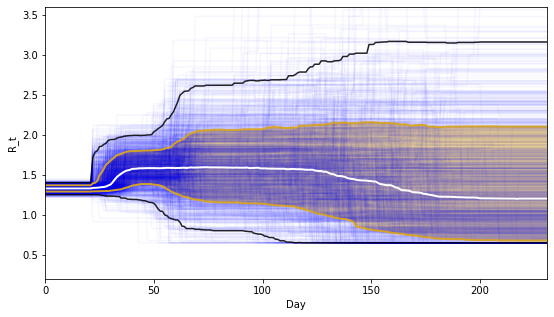

In [21]:
# plot the effective R_t over ensembles
model_days=240
t_arr = np.empty((1000, model_days))
for i in range(1000):
  
  # scenario variables
  R_t_L5 = 1.33*np.random.normal(1.0, 0.03)
  R_t_L4 = np.maximum(0.85, R_t_L5*np.random.normal(1.20, 0.15))
  R_t_L3 = np.maximum(0.65, R_t_L4*np.random.normal(1.00, 0.25))
  R_t_L2 = np.maximum(0.65, R_t_L3*np.random.normal(1.00, 0.25))
  R_t_L1 = np.maximum(0.65, R_t_L2*np.random.normal(0.85, 0.35))
  #R_t_L1 = np.maximum(0.65, np.random.normal(0.8, 0.25))
  #R_t_L1 = 1.5 # np.maximum(0.65, np.random.normal(0.8, 0.25))

  t_startL5 = -1
  t_startL4 = int(np.maximum(21, np.random.normal(30, 7)))
  t_startL3 = int(np.maximum(41, np.random.normal(60, 7)))
  t_startL2 = int(np.random.normal(120, 21))
  t_startL1 = int(np.random.normal(150, 28))

  t = np.empty(model_days)
  for j in range(model_days):
    t[j] = time_varying_reproduction(j)
    #t[j] = time_varying_reproduction_National_Model(j)

  plt.plot(t, color='blue', alpha=0.035)
  plt.ylabel("R_t")
  plt.xlabel("Day")
  t_arr[i,:] = t

median = np.empty(model_days)
percentile_sig_l = np.empty(model_days)
percentile_sig_h = np.empty(model_days)
percentile_2sig_l = np.empty(model_days)
percentile_2sig_h = np.empty(model_days)
for day in range(t_arr.shape[1]):
  median[day] = np.median(t_arr[:,day])
  percentile_sig_l[day] = np.percentile(t_arr[:,day], 16)
  percentile_sig_h[day] = np.percentile(t_arr[:,day], 84)
  percentile_2sig_l[day] = np.percentile(t_arr[:,day], 2.5)
  percentile_2sig_h[day] = np.percentile(t_arr[:,day], 97.5)

plt.ylim(0.2, 3.6)
plt.xlim(0, 231)


plt.plot(range(model_days), percentile_sig_l, linewidth = 2, color='goldenrod', alpha=0.95)
plt.plot(range(model_days), percentile_sig_h, linewidth = 2, color='goldenrod', alpha=0.95)
plt.plot(range(model_days), percentile_2sig_l, color='k', alpha=0.85)
plt.plot(range(model_days), percentile_2sig_h, color='k', alpha=0.85)
plt.plot(range(model_days), median, linewidth = 2, color = 'white')
plt.fill_between(range(model_days), percentile_sig_l, percentile_sig_h,  facecolor='goldenrod', alpha=0.5)

fig = plt.gcf()
fig.set_size_inches(9, 5)

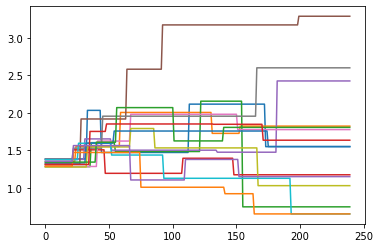

In [23]:
# plot a few specific R_t curves to show broad behaviour
for i in range(15):
  plt.plot(t_arr[np.random.randint(t_arr.shape[0]),:])#, color = 'blue', alpha=0.6 )

## Non-Pharmaceutical Intervention Scenario



### Ensembles

Got to run:  199
Got to run:  399
Got to run:  599
Got to run:  799
Got to run:  999


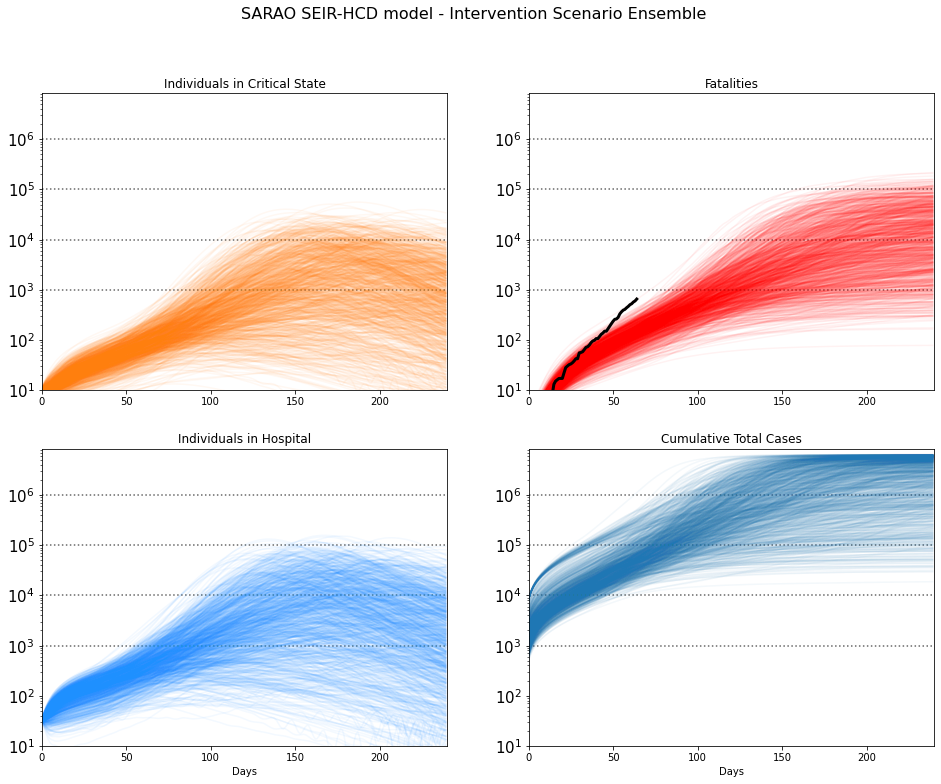

In [24]:
model_days = 240
N_RUNS = 1000

i_scenarios = []
ifr_list = []
R_0_list = []
attack_list = []
ifr_max = 10
ifr_min = 0.0

for i in range(N_RUNS):
  if i%200 == 199: 
    print('Got to run: ', i)
  # 'Scenario' parameters: draw from distributions of plausible values for R_t as well as the dates on which interventions will be enacted
  R_t_L5 = 1.33*np.random.normal(1.0, 0.03)
  R_t_L4 = np.maximum(0.85, R_t_L5*np.random.normal(1.20, 0.15))
  R_t_L3 = np.maximum(0.65, R_t_L4*np.random.normal(1.00, 0.25))
  R_t_L2 = np.maximum(0.65, R_t_L3*np.random.normal(1.00, 0.25))
  R_t_L1 = np.maximum(0.65, R_t_L2*np.random.normal(0.85, 0.35))

  t_startL5 = -1
  t_startL4 = int(np.maximum(21, np.random.normal(30, 7)))
  t_startL3 = int(np.maximum(41, np.random.normal(60, 7)))
  t_startL2 = int(np.random.normal(120, 21))
  t_startL1 = int(np.random.normal(150, 28))

  # Epidemiological parameters
  R_0 = np.random.normal(2.7, 0.35)
  t_incu = np.random.normal(5.1, 0.325) # average incubation period: "median incubation period was estimated to be 5.1 days (95% CI, 4.5 to 5.8 days) https://www.acpjournals.org/doi/10.7326/M20-0504
  # "The mean incubation period was 5.2 days (95% confidence interval [CI], 4.1 to 7.0), with the 95th percentile of the distribution at 12.5 days." https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
  # t_infect = np.maximum(3,np.random.normal(6.5, 1.75)) # average infectious period  https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30196-1/fulltext  # also see https://theconversation.com/how-long-are-you-infectious-when-you-have-coronavirus-135295
  # 2.3 days (95% CI, 0.8–3.0 days) before symptom onset and peaked at 0.7 days (95% CI, −0.2–2.0 days) before symptom onset (Fig. 1c). The estimated proportion of presymptomatic transmission (area under the curve) was 44% (95% CI, 25–69%). Infectiousness was estimated to decline quickly within 7 days. https://www.nature.com/articles/s41591-020-0869-5
  t_infect = np.maximum(2, np.random.normal(9.3, 1.15)) #t_infect = np.maximum(3,np.random.normal(9.3, 1.15)) NB - changed to range over which density of infectiousness was 1%
  t_hosp = np.maximum(3, np.random.normal(10.4, 4)) # time in hospital before transitioning to either critical or recovered https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf
  t_crit = np.maximum(3, np.random.normal(10, 2)) # average time patient is critical before transition to recovered or dead    https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf

  frac_asymptomatic = np.minimum(0.96, np.random.normal(0.75, 0.15)) #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
  frac_tested_mild = np.minimum(0.96, np.random.normal(0.85, 0.05)) # ratio of tested infections that are mild. [CCDC]
  frac_mild_total = 1-((1-frac_asymptomatic) * (1 - frac_tested_mild))
  # ToDo: use National Model parameters?

  # https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30196-1/fulltext use 30% for frac_crit and 50% for frac_fatal
  # https://www.medrxiv.org/content/10.1101/2020.04.23.20076042v1.full.pdf: 33% of all severe cases died, so in combination, the two numbers that follow must be able to give this:
  frac_crit = np.maximum(0.17, np.random.normal(0.31, 0.07)) # fraction of severe cases that become critical: 33% died, 49% discharged, 17% continue receiveing care, 17% required ICU: 45% died, 31% discharged 
  # all those that die must go through critical first
  frac_fatal = np.maximum(0.2, np.random.normal(0.56, 0.06))  # fraction of critical cases that result in death: https://www.medrxiv.org/content/10.1101/2020.04.23.20076042v1.full.pdf
  # "of [those in ICU], 31% were discharged alive, 45% died and 24% continued to receive care at the reporting date" so fatality rate of those in ICU is: 0.45+(0.45*0.24) = 0.558

  n_infected = n_tested_active * (1/(1-frac_asymptomatic))
  n_exposed = n_infected * 1.7 #(R_t^(time from infection to test)/t_inf ~ 2)*n_infected
  n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic))

  initial_state = [(N - n_infected)/N, n_exposed/N, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N] #S, E, I, R, H, C, D  
  
  # Model a variable immune fraction 
  #frac_immune = np.minimum(np.maximum(0.05, np.random.normal(0.2, 0.15)), 0.9)
  #initial_state = [(1-frac_immune)*(N-n_infected)/N, n_exposed/N, n_infected/N, ((frac_immune)*(N-n_infected-n_recovered))/N, n_hosp/N, n_crit/N, n_dead/N]

  #args = (time_varying_reproduction_National_Model, t_incu, t_infect, t_hosp, t_crit, frac_mild_total, frac_crit, frac_fatal)
  args = (time_varying_reproduction, t_incu, t_infect, t_hosp, t_crit, frac_mild_total, frac_crit, frac_fatal)
  #args = (R_0, t_incu, t_infect, t_hosp, t_crit, frac_mild_total, frac_crit, frac_fatal)

  # run solver and save to solution nparray
  sol = solve_ivp(SEIR_HCD_model, [0, model_days], initial_state, args=args, t_eval=np.arange(model_days))
  ifr = 100*sol.y[6][-1]/sol.y[3][-1]   
  old_sol = sol

  if (ifr < ifr_max) & (ifr > ifr_min): 
    i_scenarios.append(sol)
    ifr_list.append(ifr)
  else:
    i_scenarios.append(old_sol)
  
  attack_list.append(sol.y[3][-1])
  R_0_list.append(R_0)

  #if sol.y[3][-1] > 0.9: 
  #  print(args, ifr, sol.y[3][-1])

plot_ensemble(N, i_scenarios, 0.05, title = "SARAO SEIR-HCD model - Intervention Scenario Ensemble")

### Histograms

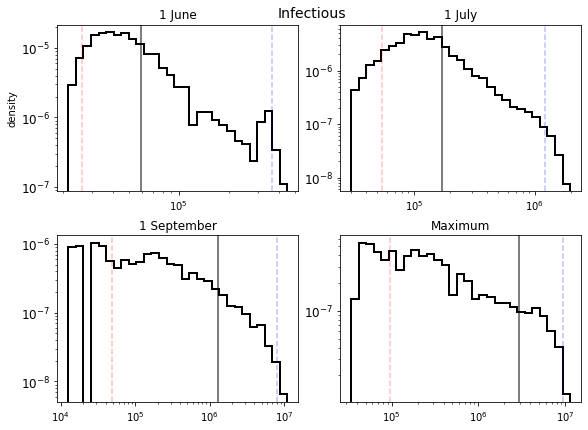

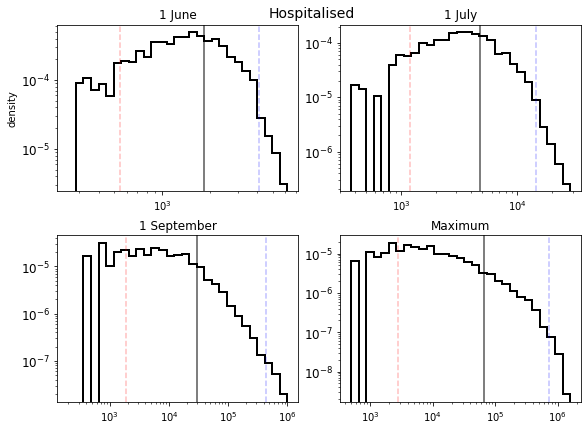

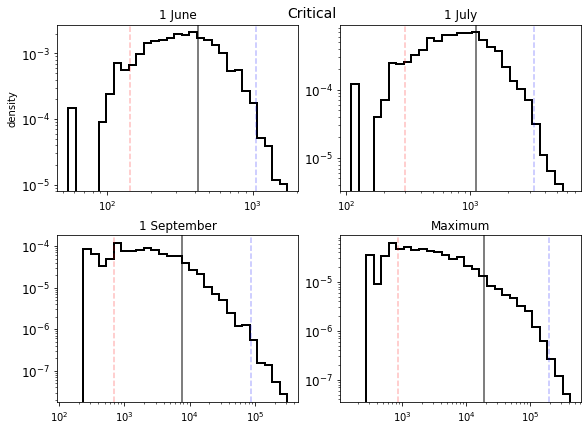

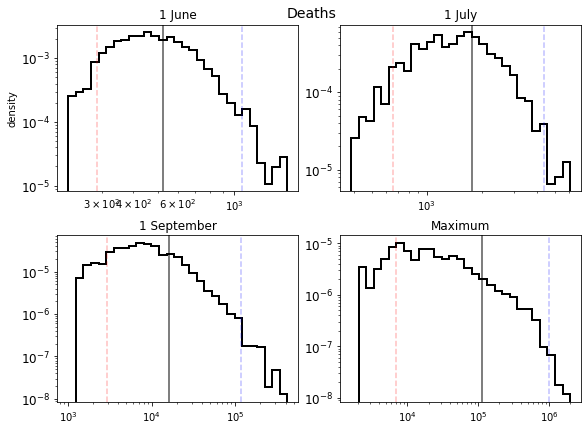

In [0]:
is_arr = np.empty([N_RUNS, sol.y.shape[0], sol.y.shape[1]]) # i.e. make it, for instance [1000, 7, 240] 
#print(is_arr.shape)
colorvec = ['orange','red','dodgerblue','blue']

for idx, sol in enumerate(i_scenarios):
  is_arr[idx,:,:] = sol.y

# days of evaluation should correspond to [1 June, 1 July, 1 September
eval_days = [31,61,122]

compartment_labels = ['Susceptible', 'Exposed', 'Infectious', 'Recovered', 'Hospitalised', 'Critical', 'Deaths']
show_labels = ['Infectious', 'Hospitalised', 'Critical', 'Deaths']

for idx, scen in enumerate(np.rollaxis(is_arr[:,[compartment_labels.index(show_labels[0]), compartment_labels.index(show_labels[1]), compartment_labels.index(show_labels[2]), compartment_labels.index(show_labels[3])],:], 1)):
    
    colour_plot = 'k' #colorvec[idx-1]
    plot_hist(scen, colour_plot,title = show_labels[idx], days=eval_days)

# for reference: sus, exp, inf, rec, hosp, crit, death = solution.y
# cases = (inf + rec + hosp + crit + death) 

# Scratch

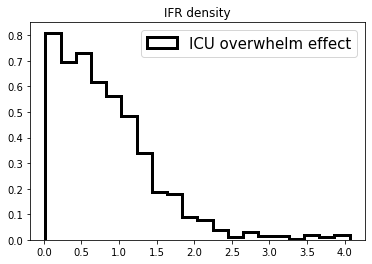

In [0]:
#ifr_list_ALL_ON = ifr_list
plt.hist(ifr_list, bins = 20, density=True, histtype='step', linewidth = '3', color='k')
#plt.hist(ifr_list, bins = 20, density=True, histtype='step', linewidth = '1', color='white')
#plt.hist(ifr_list_ALL_ON, bins = 20, density=True, histtype='step', linewidth = '3', color='r')
#plt.hist(ifr_list_ALL_ON, bins = 20, density=True, histtype='step', linewidth = '1', color='b')

plt.title("IFR density")
np.mean(ifr_list), np.median(ifr_list)

plt.legend(['ICU overwhelm effect','Without ICU Overwhelm effect'], fontsize=15)
fig = plt.gcf()
fig.set_size_inches(6, 4)
# IFR estimate for China of 0.66% (0.39%-1.33%) https://www.medrxiv.org/content/10.1101/2020.03.09.20033357v1.full.pdf

0.46321039504827183

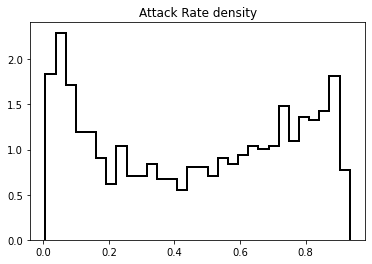

In [0]:
plt.hist(attack_list, bins = 30, density=True, histtype='step', linewidth = '2', color='k')#log=True, 
plt.title("Attack Rate density")
np.mean(attack_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


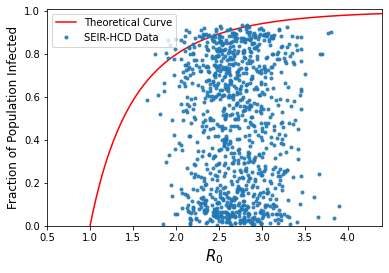

In [0]:
# BB comparison to theoretical unmitigated
# note: this plot is only valid if a constant value of R_t = R_0 is used above
def fun(x, R0):
    return np.log(1-x) + R0*x

r0_l = np.arange(1.0+1e-5,4.5,0.025)
a_l = []
for R0 in r0_l:

  xval = brentq(lambda x: fun(x, R0), 1e-8, 1)
  #print(R0,xval) # fun(xval,R0))
  a_l.append(xval)


plt.plot(r0_l,a_l, color = 'r')
xt = [0.5,4.5]
yt = [0.95,0.95]
plt.plot(R_0_list,attack_list,'.', alpha = 0.85)
#plt.plot(xt,yt)
plt.xlim(0.5,4.4)
plt.ylim(0.0,1.01)
plt.xlabel('$R_0$', fontsize = 15)
plt.ylabel('Fraction of Population Infected', fontsize = 12)
plt.legend(['Theoretical Curve','SEIR-HCD Data'])

In [0]:
#test ICU_Overload logic
ratio_fatal=0.2
ICU_CAPACITY = 4000 # [ref]   
for C in [-1, 0, 1000, 3999, 4000, 4001, 5000, 10000, 100000, 1e7]:
  # account for ICU overload by modifying the fatality ratio
  if C > ICU_CAPACITY: 
    ratio_fatal = ((C - ICU_CAPACITY)/C)*np.maximum(0.8, np.random.normal(0.6, 0.15)) + ICU_CAPACITY/C*ratio_fatal #0.8 #
  
  print(ratio_fatal)

0.2
0.2
0.2
0.2
0.2
0.20014996250937267
0.32011997000749814
0.6080479880029992
0.79232191952012
0.7999969287678081


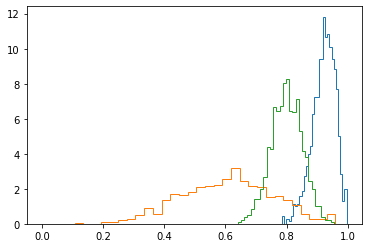

In [0]:
# distribution for frac_mild_tested
ra=np.empty(N_RUNS)
ru=np.empty(N_RUNS)
rm=np.empty(N_RUNS)
for i in range(N_RUNS):
  frac_asymptomatic = np.minimum(0.96, np.random.normal(0.60, 0.15)) #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
  frac_tested_mild = np.minimum(0.96, np.random.normal(0.80, 0.05)) # ratio of infections that are mild. 
  frac_mild_total = 1-((1-frac_asymptomatic) * (1 - frac_tested_mild))
  ra[i] = frac_mild_total
  ru[i] = frac_asymptomatic
  rm[i] = frac_tested_mild
plt.hist(ra, bins=30, density=True,histtype='step')
plt.hist(ru, bins=30, density=True,histtype='step')
plt.hist(rm, bins=30, density=True,histtype='step')
k=stats.gaussian_kde(ra, bw_method=30)
plt.plot(range(0,1,30), k(range(0,1,30)))
ra.shape

symptomatic_frac = 0.5    # Vo, Diamond Princess 
symptomatic_frac_tested = 0.1#??   # Country specific 
# IFR = 1% = dead(t)/counts(t-14)

mild_frac_of_cases = 0.8  #CFR 
fraction_tested = (symptomatic_frac)*symptomatic_frac_tested*mild_frac_of_cases
